In [21]:
import os
import glob
import time
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy.ndimage import convolve
from astropy.io import fits
import astropy.units as u
from astropy.io.fits import getval
from astropy.stats import sigma_clipped_stats, SigmaClip, sigma_clip
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astroquery.vizier import Vizier
from photutils.background import Background2D, MedianBackground
import matplotlib.pyplot as plt
import argparse
import image_registration
import warnings
warnings.filterwarnings('ignore')

In [22]:
def load_fits(image, extension=0):
    with fits.open(image) as hdu:
        header = hdu[extension].header
        data = hdu[extension].data
    return data, header


def delete_extra_file(file):
    try:
        os.remove(file)
    except:
        print(file, 'file not found to delete')
        

def get_table_from_ldac(filename, frame=1):
    # To read cat file generated by sextractor
    from astropy.table import Table
    if frame > 0:
        frame = frame*2
    tbl = Table.read(filename, hdu=frame)
    return tbl

In [23]:
def get_cam_parametres():
    ra_keyword = "TARRA"
    dec_keyword = "TARDEC"
    filt_keyword = "Filter"
    exp_time_keyword = 'EXPOSURE'
    jd_keyword = 'JD'
    objet_keyword = 'OBJECT'
    x_len = 4108
    y_len = 4096
    pix_scale = 0.676
    gain = 1.6  # in e-/ADU
    saturLevel = 51000  # in adu
    photoDistThresh = 1.2  # to cross match vizier and sex catalogue
    boxsize = 20  # for vizier query
    maxmag = 18  # for vizier query
    readNoise = 12.0  # in electrons
    return ra_keyword, dec_keyword, filt_keyword, exp_time_keyword, jd_keyword, objet_keyword, x_len, y_len, pix_scale, gain, saturLevel, photoDistThresh, boxsize, maxmag, readNoise


In [24]:
def get_params_of_image(image):
    ra_keyword, dec_keyword, filt_keyword, exp_time_keyword, jd_keyword, objet_keyword, _, _, _, _, _, _, _, _, _, = get_cam_parametres()
    data, header = load_fits(image)
    tar_ra = header[ra_keyword]
    tar_dec = header[dec_keyword]
    filt = header[filt_keyword]
    exp_time = header[exp_time_keyword]
    jd = header[jd_keyword]
    object_name = header[objet_keyword]
    return tar_ra, tar_dec, filt, exp_time, jd, object_name


In [25]:
def get_configfile_names(config_path):
    sex_config = config_path + 'astrom.sex'
    sex_param = config_path + 'astrom.param'
    psfex_config = config_path + 'photometry.psfex'
    sex_psf_param = config_path + 'sex_PSF.param'

    # sex_config = config_path + 'photomCat.sex'
    # sex_param = config_path + 'photomCat.param'
    # psfex_config = config_path + 'psfex_conf.psfex'
    # sex_psf_param = config_path + 'photomPSF.param'
    return sex_config, sex_param, psfex_config, sex_psf_param


In [26]:
def run_sextractor(image, gain, saturLevel, sex_config, sex_param):
    # Running sex to get cat file for masking (and to get_psf)
    sex_cmd = f"source-extractor -c {sex_config} {image} -CATALOG_NAME {image}.cat -GAIN {gain} -SATUR_LEVEL {saturLevel} -WEIGHT_TYPE NONE -PARAMETERS_NAME {sex_param}"
    # print(sex_cmd)
    try:
        os.system(sex_cmd)
    except:
        print(f"Could not run sex on {image}")
    # output catfile is image+'.cat'
    return


In [27]:
def get_psf(image, psfex_config):
    catfile = image+'.cat'
    # running PSFex to get psf
    psfex_cmd = f"psfex -c {psfex_config} {catfile}"
    print(psfex_cmd)
    try:
        os.system(psfex_cmd)
    except:
        print(f"Could not run PSFex on {image}")
    # saving psf model
    image_psf = image + '.psf'
    psf_data = fits.open(image_psf)[1].data[0][0][0]
    psf_data = psf_data / np.sum(psf_data)
    psf_model_hdu = fits.PrimaryHDU(psf_data)
    psf_model_hdu.writeto(image + '.psfmodel', overwrite=True)
    # removing extra files
    delete_extra_file(catfile)
    return psf_data


In [28]:
def run_sextractor_with_PSF(image, gain, saturLevel, sex_config, sex_psf_param):
    # Running PSF Sextractor to get psf_cat file
    image_psf = image + '.psf'
    sex_psf_cmd = f"source-extractor -c {sex_config} {image} -CATALOG_NAME {image}.psf.cat -GAIN {gain} -SATUR_LEVEL {saturLevel} -WEIGHT_TYPE NONE -PSF_NAME {image_psf} -PARAMETERS_NAME {sex_psf_param}"
    try:
        os.system(sex_psf_cmd)
    except:
        print(f"Could not run psf sex on {image}")
    # removing extra files
    delete_extra_file(image_psf)
    return


## After saving the generated psf, no need to run it again

In [29]:
images = glob.glob('/home/aditi/ksp/u-band/data/*.wcs.proc.fits')
config_path = '/home/aditi/ksp/u-band/data/'
os.chdir(os.path.dirname(images[0]))
for image in images:
    ra_keyword, dec_keyword, filt_keyword, exp_time_keyword, jd_keyword, objet_keyword, x_len, y_len, pix_scale, gain, saturLevel, photoDistThresh, boxsize, maxmag, readNoise = get_cam_parametres()
    tar_ra, tar_dec, filt, exp_time, jd, object_name = get_params_of_image(image)
    sex_config, sex_param, psfex_config, sex_psf_param = get_configfile_names(
        config_path)
    run_sextractor(image, gain, saturLevel, sex_config, sex_param)
    psf_data = get_psf(image, psfex_config)
    run_sextractor_with_PSF(image, gain, saturLevel, sex_config, sex_psf_param)


> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:23 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524181219-697-RA.wcs.proc.fits
----- Measuring from: 20230524181219-697-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -9.34159   RMS: 9.53547    / Threshold: 95.3547    
> Scanning image
> Line:   25  Objects:     

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230524181219-697-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:25 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524181219-697-RA.wcs.proc.fits
----- Measuring from: 20230524181219-697-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230524182956-255-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:27 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524182956-255-RA.wcs.proc.fits
----- Measuring from: 20230524182956-255-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230603150440-866-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:29 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603150440-866-RA.wcs.proc.fits
----- Measuring from: 20230603150440-866-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230606150133-789-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:32 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230606150133-789-RA.wcs.proc.fits
----- Measuring from: 20230606150133-789-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230525190806-207-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:33 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525190806-207-RA.wcs.proc.fits
----- Measuring from: 20230525190806-207-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605171802-571-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:36 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605171802-571-RA.wcs.proc.fits
----- Measuring from: 20230605171802-571-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230527145847-598-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:38 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527145847-598-RA.wcs.proc.fits
----- Measuring from: 20230527145847-598-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230523210507-283-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:41 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230523210507-283-RA.wcs.proc.fits
----- Measuring from: 20230523210507-283-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230526154827-798-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:44 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526154827-798-RA.wcs.proc.fits
----- Measuring from: 20230526154827-798-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230528152154-632-RA.wcs.proc.fits.cat


> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 17.051     RMS: 12.5328    / Threshold: 125.328    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects:        0 detected /        0 sextracted
> Line:   10  Objects:        0 detected /

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230604153430-706-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:48 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604153430-706-RA.wcs.proc.fits
----- Measuring from: 20230604153430-706-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230521150712-428-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:50 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521150712-428-RA.wcs.proc.fits
----- Measuring from: 20230521150712-428-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230528153545-876-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:52 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230528153545-876-RA.wcs.proc.fits
----- Measuring from: 20230528153545-876-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605170408-218-RA.wcs.proc.fits.cat


> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.65538   RMS: 12.5669    / Threshold: 125.669    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230606151509-544-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:52:56 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230606151509-544-RA.wcs.proc.fits
----- Measuring from: 20230606151509-544-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230526153424-267-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:01 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526153424-267-RA.wcs.proc.fits
----- Measuring from: 20230526153424-267-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230604152014-648-RA.wcs.proc.fits.cat


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -40.9111   RMS: 12.6253    / Threshold: 126.253    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230527151004-669-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:05 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527151004-669-RA.wcs.proc.fits
----- Measuring from: 20230527151004-669-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230530174805-262-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:07 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230530174805-262-RA.wcs.proc.fits
----- Measuring from: 20230530174805-262-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230530174526-200-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:09 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230530174526-200-RA.wcs.proc.fits
----- Measuring from: 20230530174526-200-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230603152111-230-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:12 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603152111-230-RA.wcs.proc.fits
----- Measuring from: 20230603152111-230-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230527151243-755-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:15 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527151243-755-RA.wcs.proc.fits
----- Measuring from: 20230527151243-755-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230603150719-943-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:16 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603150719-943-RA.wcs.proc.fits
----- Measuring from: 20230603150719-943-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230520151245-818-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:19 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230520151245-818-RA.wcs.proc.fits
----- Measuring from: 20230520151245-818-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230603151832-158-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:21 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603151832-158-RA.wcs.proc.fits
----- Measuring from: 20230603151832-158-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230525185233-041-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:23 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525185233-041-RA.wcs.proc.fits
----- Measuring from: 20230525185233-041-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605161844-365-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:26 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605161844-365-RA.wcs.proc.fits
----- Measuring from: 20230605161844-365-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230530175948-598-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:28 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230530175948-598-RA.wcs.proc.fits
----- Measuring from: 20230530175948-598-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230522153940-706-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:31 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522153940-706-RA.wcs.proc.fits
----- Measuring from: 20230522153940-706-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230528153824-950-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:34 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230528153824-950-RA.wcs.proc.fits
----- Measuring from: 20230528153824-950-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230523210158-212-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:36 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230523210158-212-RA.wcs.proc.fits
----- Measuring from: 20230523210158-212-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230521154549-744-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:40 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521154549-744-RA.wcs.proc.fits
----- Measuring from: 20230521154549-744-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230526153145-192-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:42 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526153145-192-RA.wcs.proc.fits
----- Measuring from: 20230526153145-192-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230522154249-788-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:45 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522154249-788-RA.wcs.proc.fits
----- Measuring from: 20230522154249-788-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605153116-506-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:47 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605153116-506-RA.wcs.proc.fits
----- Measuring from: 20230605153116-506-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230527145608-545-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:49 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527145608-545-RA.wcs.proc.fits
----- Measuring from: 20230527145608-545-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605170129-147-RA.wcs.proc.fits.cat


> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 4.97542    RMS: 12.503     / Threshold: 125.03     
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects:        0 detected /        0 sextracted
> Line:   10  Objects:        0 detected /

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230604153151-631-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:54 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604153151-631-RA.wcs.proc.fits
----- Measuring from: 20230604153151-631-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230525184923-965-RA.wcs.proc.fits.cat


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -29.7052   RMS: 12.1675    / Threshold: 121.675    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        1 detected /

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230525191115-290-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:53:59 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525191115-290-RA.wcs.proc.fits
----- Measuring from: 20230525191115-290-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230526154548-720-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:02 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526154548-720-RA.wcs.proc.fits
----- Measuring from: 20230526154548-720-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230522152401-684-RA.wcs.proc.fits.cat


> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -82.6938   RMS: 12.5596    / Threshold: 125.596    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects:        0 detected /        0 sextracted


psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230522152710-757-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:06 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522152710-757-RA.wcs.proc.fits
----- Measuring from: 20230522152710-757-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230521151021-504-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:09 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521151021-504-RA.wcs.proc.fits
----- Measuring from: 20230521151021-504-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605171523-499-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:11 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605171523-499-RA.wcs.proc.fits
----- Measuring from: 20230605171523-499-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605145608-869-RA.wcs.proc.fits.cat


> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -24.7574   RMS: 12.2862    / Threshold: 122.862    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects:        0 detected /        0 sextracted


psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230528152433-706-RA.wcs.proc.fits.cat



> WARNING: 1st context group removed (not enough samples)


*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:15 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230528152433-706-RA.wcs.proc.fits
----- Measuring from: 20230528152433-706-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting 

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230524183305-331-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:17 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524183305-331-RA.wcs.proc.fits
----- Measuring from: 20230524183305-331-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605161605-293-RA.wcs.proc.fits.cat


> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 3.84512    RMS: 12.3146    / Threshold: 123.146    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /        0 sextracted
> Line:    9  Objects

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230604151735-580-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:21 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604151735-580-RA.wcs.proc.fits
----- Measuring from: 20230604151735-580-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230530175709-516-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:24 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230530175709-516-RA.wcs.proc.fits
----- Measuring from: 20230530175709-516-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605145329-795-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:27 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605145329-795-RA.wcs.proc.fits
----- Measuring from: 20230605145329-795-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230525195013-722-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:30 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525195013-722-RA.wcs.proc.fits
----- Measuring from: 20230525195013-722-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230605153355-567-RA.wcs.proc.fits.cat


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -12.9805   RMS: 12.4252    / Threshold: 124.252    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracted
> Line:    3  Objects:        0 detected /        0 sextracted
> Line:    4  Objects:        0 detected /        0 sextracted
> Line:    5  Objects:        0 detected /        0 sextracted
> Line:    6  Objects:        0 detected /        0 sextracted
> Line:    7  Objects:        0 detected /        0 sextracted
> Line:    8  Objects:        0 detected /

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230520151524-890-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:34 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230520151524-890-RA.wcs.proc.fits
----- Measuring from: 20230520151524-890-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

psfex -c /home/aditi/ksp/u-band/data/photometry.psfex /home/aditi/ksp/u-band/data/20230524181528-778-RA.wcs.proc.fits.cat



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.

> 
----- Source Extractor 2.25.0 started on 2024-07-29 at 14:54:37 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524181528-778-RA.wcs.proc.fits
----- Measuring from: 20230524181528-778-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s

## Use generated psf to fit selected sources of the images

In [30]:
def psf_fit(backsub_cutout, psf_data):
    backsub_cutout = backsub_cutout[15: 45, 15: 45]
    psf_data = psf_data[15: 45, 15: 45]
    xoff, yoff, exoff, eyoff = image_registration.chi2_shifts.chi2_shift(
        psf_data, backsub_cutout, 10, boundary='wrap', nfitted=2, upsample_factor='auto')
    print(
        f"peak of source detected at offset {xoff, yoff} (in pixel) from target position")
    if abs(xoff) > 5.0 or abs(yoff) > 5.0:
        # xoff = 0.0
        # yoff = 0.0
        phot_type = 'Forced_PSF'
    else:
        phot_type = 'PSF'
    resize_backsub_cutout = image_registration.fft_tools.shift2d(
        backsub_cutout, -xoff, -yoff)
    flux = np.sum(resize_backsub_cutout*psf_data)/np.sum(psf_data*psf_data)
    # convolved = convolve(resize_backsub_cutout, psf_data, mode='constant')
    # flux = np.sum(convolved)
    return flux, phot_type


In [31]:
def cal_inst_mag(psf_data, image, x_list, y_list):
    saturLevel = 51000
    image_data, image_header = load_fits(image)
    jd = getval(image, 'JD')
    filt = getval(image, 'FILTER')
    print(os.path.basename(image), filt, jd)
    flux = []
    sigma_flux = []
    int_mag = []
    int_mag_err = []
    PSF_type = []
    is_saturated = []
    for i in range(len(x_list)):
        x = int(x_list[i])
        y = int(y_list[i])
        cutout = Cutout2D(image_data, position=(
            x, y), size=np.shape(psf_data))
        Is = cutout.data
        is_saturated_ = np.ravel(Is > saturLevel).any()
        sigma_clip = SigmaClip(sigma=3.0)
        try:
            bkg_estimator = MedianBackground()
            bkg = Background2D(Is, np.shape(psf_data), filter_size=(
                3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
            background = bkg.background
        except:
            _, background, _ = sigma_clipped_stats(Is)
        sigma_flux_ = np.sqrt(np.sum(Is*psf_data**2)) / np.sum(psf_data*psf_data)
        Is = Is-background
        flux_, PSF_type_ = psf_fit(Is, psf_data)
        int_mag_ = -2.5*np.log10(flux_)
        int_mag_err_ = 2.5*np.log10(1 + sigma_flux_/flux_)
        flux.append(flux_)
        sigma_flux.append(sigma_flux_)
        int_mag.append(int_mag_)
        int_mag_err.append(int_mag_err_)
        PSF_type.append(PSF_type_)
        is_saturated.append(is_saturated_)
    return flux, sigma_flux, int_mag, int_mag_err, PSF_type, is_saturated


In [34]:
def get_results(image, x_list, y_list):
    jd = getval(image, 'JD')
    filt = getval(image, 'FILTER')
    psf_data = fits.open(image+'.psfmodel')[0].data
    # psf_data = fits.open(os.path.dirname(image) + '/moffat_' +
    #                      os.path.basename(image)+'.fits')[0].data
    flux, sigma_flux, int_mag, int_mag_err, PSF_type, is_saturated = cal_inst_mag(
        psf_data, image, x_list, y_list)
    data = pd.DataFrame()
    add_data = pd.DataFrame(
        columns=['Image', 'Filter', 'JD', 'tar_flux', 'tar_flux_err', 'tar_int_mag', 'tar_int_mag_err', 'tar_PSF_type', 'tar_is_saturated'])
    for i in range(len(flux)):
        if i == 0:
            add_data.loc[0, 'tar_flux'] = flux[0]
            add_data.loc[0, 'tar_flux_err'] = sigma_flux[0]
            add_data.loc[0, 'tar_int_mag'] = int_mag[0]
            add_data.loc[0, 'tar_int_mag_err'] = int_mag_err[0]
            add_data.loc[0, 'tar_PSF_type'] = PSF_type[0]
            add_data.loc[0, 'tar_is_saturated'] = is_saturated[0]
        else:
            add_data[f'flux_{i-1}'] = flux[i]
            add_data[f'flux_err_{i-1}'] = sigma_flux[i]
            add_data[f'int_mag_{i-1}'] = int_mag[i]
            add_data[f'int_mag_err_{i-1}'] = int_mag_err[i]
            add_data[f'PSF_type_{i-1}'] = PSF_type[i]
            add_data[f'is_saturated_{i-1}'] = is_saturated[i]
    add_data['Image'] = os.path.basename(image)
    add_data['Filter'] = filt
    add_data['JD'] = jd
    data = pd.concat([data, add_data])
    csv_file = '/home/aditi/ksp/u-band/data/final_u_results.csv'
    data.to_csv(csv_file, mode='a', index=False,
                header=not os.path.exists(csv_file))
    print('flux:', flux)
    print('sigma_flux:', sigma_flux)
    print('int_mag:', int_mag)
    print('int_mag_err:', int_mag_err)
    print('PSF_type:', PSF_type)
    print('is_saturated:', is_saturated)
    return


In [35]:
image_1 = '/home/aditi/ksp/u-band/data/20230520151245-818-RA.wcs.proc.fits'
x_list_1 = [2524.0772, 2058.746, 1651.702, 748.26015, 585.29789, 1127.6668, 2754.0554]
y_list_1 = [2278.5419, 569.63758, 773.67909, 1693.2532, 2225.7692, 1624.4229, 1445.6512]
get_results(image_1, x_list_1, y_list_1)

image_2 = '/home/aditi/ksp/u-band/data/20230520151524-890-RA.wcs.proc.fits'
x_list_2 = [2524.0772, 2058.746, 1652.8594, 748.26015, 585.29789, 1127.6668, 2754.0554]
y_list_2 = [2278.5419, 569.63758, 775.41517,
          1693.2532, 2225.7692, 1624.4229, 1445.6512]
get_results(image_2, x_list_2, y_list_2)


20230520151245-818-RA.wcs.proc.fits u 2460085.13385417
peak of source detected at offset (-2.33203125, 1.23828125) (in pixel) from target position
peak of source detected at offset (-1.103515625, 1.556640625) (in pixel) from target position
peak of source detected at offset (1.06640625, 2.98828125) (in pixel) from target position
peak of source detected at offset (-1.97265625, 0.76953125) (in pixel) from target position
peak of source detected at offset (-0.423828125, 0.236328125) (in pixel) from target position
peak of source detected at offset (-0.365234375, 1.146484375) (in pixel) from target position
peak of source detected at offset (-0.3515625, 0.5859375) (in pixel) from target position
flux: [32228.924053683804, 5263.561776428429, 6631.1172470856345, 9073.97706425775, 5670.008319502887, 54242.74381170643, 14015.715880128522]
sigma_flux: [119.81998955573432, 55.59799382957375, 51.84628058661492, 69.73528842924746, 79.6114756961398, 256.57531538232814, 133.9276522922732]
int_mag: 

In [36]:
image_3 = '/home/aditi/ksp/u-band/data/20230521154549-744-RA.wcs.proc.fits'
x_list_3 = [2472.2376, 2382.2252, 1942.8332,
            862.30729, 591.26981, 1248.6259, 2876.4798]
y_list_3 = [2380.4931, 611.9387, 726.40137,
            1430.5992, 1915.2292, 1444.7123, 1615.851]
get_results(image_3, x_list_3, y_list_3)


20230521154549-744-RA.wcs.proc.fits u 2460086.15681593
peak of source detected at offset (-0.423828125, -0.404296875) (in pixel) from target position
peak of source detected at offset (-0.81640625, -0.01171875) (in pixel) from target position
peak of source detected at offset (-0.212890625, -0.431640625) (in pixel) from target position
peak of source detected at offset (-0.708984375, -0.314453125) (in pixel) from target position
peak of source detected at offset (-0.66015625, -0.44140625) (in pixel) from target position
peak of source detected at offset (-0.306640625, -0.458984375) (in pixel) from target position
peak of source detected at offset (-0.330078125, -0.638671875) (in pixel) from target position
flux: [97153.18647707519, 6018.850548792343, 7616.577591329309, 10456.34139929058, 5880.353945914646, 62314.70829799092, 15614.9625957581]
sigma_flux: [375.97257682859146, 82.99758886236086, 100.62743854285742, 115.4875205123919, 82.93189213185872, 302.5783335856829, 145.704249712458

In [37]:
# check images are not good, have lots of fringes

# image_4 = '/home/growth/SN2023ixf/u_band/20230522152401-684-RA.wcs.proc.fits'
# x_list_4 = [2510.936, 2270.43, 1839.6376,
#             826.47548, 597.24178, 1212.7941, 2846.3811]
# y_list_4 = [2346.0946, 590.43962, 744.4606,
#             1535.1086, 2045.8003, 1516.3759, 1552.2137]
# get_results(image_4, x_list_4, y_list_4)

# image_5 = '/home/growth/SN2023ixf/u_band/20230522152710-757-RA.wcs.proc.fits'
# get_results(image_5, x_list_4, y_list_4)

# image_6 = '/home/growth/SN2023ixf/u_band/20230522153940-706-RA.wcs.proc.fits'
# get_results(image_6, x_list_4, y_list_4)

# image_7 = '/home/growth/SN2023ixf/u_band/20230522154249-788-RA.wcs.proc.fits'
# get_results(image_7, x_list_4, y_list_4)

In [38]:
image_8 = '/home/aditi/ksp/u-band/data/20230523210158-212-RA.wcs.proc.fits'
x_list_8 = [1536.9917, 2977.8059, 3161.6682, 3281.5885, 3067.8812, 3033.6559, 1885.9746]
y_list_8 = [2204.8978, 3232.7526, 2814.0326,
            1530.6809, 1019.1973, 1824.5089, 2996.5819]
get_results(image_8, x_list_8, y_list_8)

image_9 = '/home/aditi/ksp/u-band/data/20230523210507-283-RA.wcs.proc.fits'
get_results(image_9, x_list_8, y_list_8)


20230523210158-212-RA.wcs.proc.fits u 2460088.37635858
peak of source detected at offset (-0.173828125, 0.212890625) (in pixel) from target position
peak of source detected at offset (0.291015625, 0.517578125) (in pixel) from target position
peak of source detected at offset (-0.16015625, 2.98046875) (in pixel) from target position
peak of source detected at offset (-0.2265625, 2.8203125) (in pixel) from target position
peak of source detected at offset (2.1796875, 0.1796875) (in pixel) from target position
peak of source detected at offset (-3.361328125, 2.978515625) (in pixel) from target position
peak of source detected at offset (-0.7421875, 0.1640625) (in pixel) from target position
flux: [114735.87027648372, 5618.400254274782, 6925.851866985655, 9599.163607916002, 5346.116902001264, 55597.5001927053, 12966.840205086371]
sigma_flux: [416.58511151618285, 79.69172574594361, 42.217740316830046, 59.48175667922721, 41.773121801651634, 66.82290387312327, 129.0015385649618]
int_mag: [-12

In [39]:
image_10 = '/home/aditi/ksp/u-band/data/20230524181219-697-RA.wcs.proc.fits'
x_list_10 = [1867.2177, 3532.9983, 3299.0781,
             2315.6776, 1775.4764, 2414.4822, 2712.3183]
y_list_10 = [2582.5937, 1995.4372, 1608.112,
             770.12924, 649.41956, 1145.4818, 2754.6875]
get_results(image_10, x_list_10, y_list_10)

image_11 = '/home/aditi/ksp/u-band/data/20230524181528-778-RA.wcs.proc.fits'
get_results(image_11, x_list_10, y_list_10)

# image_12 = '/home/growth/SN2023ixf/u_band/20230524182956-255-RA.wcs.proc.fits'
# get_results(image_12, x_list_10, y_list_10)

# image_13 = '/home/growth/SN2023ixf/u_band/20230524183305-331-RA.wcs.proc.fits'
# get_results(image_13, x_list_10, y_list_10)


20230524181219-697-RA.wcs.proc.fits u 2460089.25855113
peak of source detected at offset (-4.462890625, 2.494140625) (in pixel) from target position
peak of source detected at offset (0.783203125, 1.009765625) (in pixel) from target position
peak of source detected at offset (-3.97265625, 0.02734375) (in pixel) from target position
peak of source detected at offset (1.640625, 0.953125) (in pixel) from target position
peak of source detected at offset (-0.103515625, -0.330078125) (in pixel) from target position
peak of source detected at offset (-1.04296875, 0.23828125) (in pixel) from target position
peak of source detected at offset (-1.01953125, 0.58203125) (in pixel) from target position
flux: [15351.33747200301, 809.6393152508887, 1464.7602854826562, 1250.5310466192243, 713.8864287883233, 7023.777572552788, 1738.7450731088775]
sigma_flux: [37.505976975146666, 27.568605604611065, 30.006404350870646, 28.976247291088228, 28.40712969966591, 85.3219454565812, 40.41749501786601]
int_mag:

In [40]:
image_14 = '/home/aditi/ksp/u-band/data/20230525184923-965-RA.wcs.proc.fits'
x_list_14 = [1797.4461, 3514.4231, 3316.4616,
            2414.7454, 1886.2915, 2476.399, 2628.983]
y_list_14 = [2578.2504, 2144.0389, 1735.6385,
            813.47139, 642.53338, 1195.0157, 2826.3091]
get_results(image_14, x_list_14, y_list_14)


image_15 = '/home/aditi/ksp/u-band/data/20230525185233-041-RA.wcs.proc.fits'
get_results(image_15, x_list_14, y_list_14)


image_16 = '//home/aditi/ksp/u-band/data/20230525190806-207-RA.wcs.proc.fits'
get_results(image_16, x_list_14, y_list_14)

image_17 = '/home/aditi/ksp/u-band/data/20230525191115-290-RA.wcs.proc.fits'
get_results(image_17, x_list_14, y_list_14)



20230525184923-965-RA.wcs.proc.fits u 2460090.28429493
peak of source detected at offset (2.255859375, 2.826171875) (in pixel) from target position
peak of source detected at offset (1.59765625, 0.71484375) (in pixel) from target position
peak of source detected at offset (1.060546875, 1.251953125) (in pixel) from target position
peak of source detected at offset (0.408203125, 2.134765625) (in pixel) from target position
peak of source detected at offset (-0.20703125, 2.98828125) (in pixel) from target position
peak of source detected at offset (0.650390625, 1.818359375) (in pixel) from target position
peak of source detected at offset (0.8828125, 0.5859375) (in pixel) from target position
flux: [122325.06924745615, 6358.928791696473, 7695.474432955149, 10418.412622429058, 6077.896884595981, 59919.39183969779, 15335.007777866935]
sigma_flux: [203.69042430829492, 72.47524323673154, 83.36669606171125, 88.11868078872762, 50.68496125642777, 237.9371977685515, 135.97806080654703]
int_mag: [

In [41]:
image_18 = '/home/aditi/ksp/u-band/data/20230526153145-192-RA.wcs.proc.fits'
x_list_18 = [2606.9094, 1599.7156, 1287.2008, 740.16616, 765.69833, 1075.3892, 2550.643]
y_list_18 = [2122.5311, 666.59863, 996.27936, 2164.4161, 2719.3248, 1972.0619, 1258.6545]
get_results(image_18, x_list_18, y_list_18)


image_19 = '/home/aditi/ksp/u-band/data/20230526153424-267-RA.wcs.proc.fits'
get_results(image_19, x_list_18, y_list_18)

image_20 = '/home/aditi/ksp/u-band/data/20230526154548-720-RA.wcs.proc.fits'
x_list_20 = [2606.9094, 1599.7156, 1287.2008, 740.16616, 763.68894, 1075.3892, 2550.643]
y_list_20 = [2122.5311, 666.59863, 996.27936,
             2164.4161, 2717.6503, 1972.0619, 1258.6545]
get_results(image_20, x_list_20, y_list_20)

image_21 = '/home/aditi/ksp/u-band/data/20230526154827-798-RA.wcs.proc.fits'
get_results(image_21, x_list_18, y_list_18)


20230526153145-192-RA.wcs.proc.fits u 2460091.14704061
peak of source detected at offset (2.193359375, -0.455078125) (in pixel) from target position
peak of source detected at offset (-0.078125, 0.578125) (in pixel) from target position
peak of source detected at offset (-0.97265625, -0.55078125) (in pixel) from target position
peak of source detected at offset (-0.8046875, -0.5078125) (in pixel) from target position
peak of source detected at offset (-0.234375, -0.609375) (in pixel) from target position
peak of source detected at offset (-0.208984375, -0.513671875) (in pixel) from target position
peak of source detected at offset (-1.955078125, 0.162109375) (in pixel) from target position
flux: [104689.23171296126, 5801.022235516573, 7210.456141327433, 10164.645467450273, 5963.497308641437, 57153.32890157621, 13419.404982970509]
sigma_flux: [270.4927720229816, 76.09414460967999, 79.29793133133784, 102.85086821945282, 75.51315202049314, 282.91882859631534, 93.39824971897961]
int_mag: [

In [42]:
image_22 = '/home/aditi/ksp/u-band/data/20230527145608-545-RA.wcs.proc.fits'
x_list_22 = [2618.054, 1530.9185, 1235.603,
             754.99462, 810.89675, 1078.7214, 2512.2115]
y_list_22 = [2085.6918, 688.09772, 1034.9777,
             2231.8069, 2784.3066, 2021.665, 1226.8586]
get_results(image_22, x_list_22, y_list_22)
image_23 = '/home/aditi/ksp/u-band/data/20230527145847-598-RA.wcs.proc.fits'
get_results(image_23, x_list_22, y_list_22)

image_24 = '/home/aditi/ksp/u-band/data/20230527151004-669-RA.wcs.proc.fits'
get_results(image_24, x_list_22, y_list_22)

image_25 = '/home/aditi/ksp/u-band/data/20230527151243-755-RA.wcs.proc.fits'
get_results(image_25, x_list_22, y_list_22)


20230527145608-545-RA.wcs.proc.fits u 2460092.12231056
peak of source detected at offset (-0.646484375, 0.373046875) (in pixel) from target position
peak of source detected at offset (-1.443359375, 0.896484375) (in pixel) from target position
peak of source detected at offset (-0.36328125, 0.71484375) (in pixel) from target position
peak of source detected at offset (-0.32421875, 0.14453125) (in pixel) from target position
peak of source detected at offset (0.009765625, -0.330078125) (in pixel) from target position
peak of source detected at offset (-0.05859375, -0.15234375) (in pixel) from target position
peak of source detected at offset (-2.8046875, 0.7734375) (in pixel) from target position
flux: [85400.95859618936, 4807.315581509557, 6020.764030864386, 8412.845611679264, 5208.384475432118, 48279.29060122204, 12067.172384154532]
sigma_flux: [339.14185917161205, 59.38949588880843, 82.86378548225973, 104.11116054429002, 79.18506492666059, 262.1530988964736, 71.04294807190557]
int_mag

In [43]:
image_26 = '/home/aditi/ksp/u-band/data/20230530174526-200-RA.wcs.proc.fits'
x_list_26 = [1816.3544, 3500.1002, 3273.72, 2309.6478,
             1770.3587, 2398.2043, 2661.5893]
y_list_26 = [2646.1857, 2090.5846, 1698.3824, 838.80834,
             708.58668, 1218.1, 2830.9547]
get_results(image_26, x_list_26, y_list_26)

image_27 = '/home/aditi/ksp/u-band/data/20230530174805-262-RA.wcs.proc.fits'
get_results(image_27, x_list_26, y_list_26)

image_28 = '/home/aditi/ksp/u-band/data/20230530175709-516-RA.wcs.proc.fits'
get_results(image_28, x_list_26, y_list_26)

image_29 = '/home/aditi/ksp/u-band/data/20230530175948-598-RA.wcs.proc.fits'
get_results(image_29, x_list_26, y_list_26)

20230530174526-200-RA.wcs.proc.fits u 2460095.23987701
peak of source detected at offset (0.052734375, -1.244140625) (in pixel) from target position
peak of source detected at offset (-1.650390625, 1.462890625) (in pixel) from target position
peak of source detected at offset (-0.763671875, -0.216796875) (in pixel) from target position
peak of source detected at offset (-0.703125, 3.203125) (in pixel) from target position
peak of source detected at offset (-0.763671875, -0.103515625) (in pixel) from target position
peak of source detected at offset (-1.326171875, -0.419921875) (in pixel) from target position
peak of source detected at offset (-0.2109375, 2.9453125) (in pixel) from target position
flux: [54657.88005711389, 3999.785943157623, 4764.934584580661, 6373.3328975291715, 3551.681884636116, 37158.31317991043, 9310.332971500338]
sigma_flux: [250.51509623023597, 23.369720789145475, 62.55288879354747, 11.420664618351516, 47.61855405080003, 195.26511898108444, 49.58668427632601]
int

In [44]:
image_30 = '/home/aditi/ksp/u-band/data/20230603151832-158-RA.wcs.proc.fits'
x_list_30 = [2669.0746, 2009.7838, 1629.9741,
             839.12801, 741.94081, 1206.9631, 2802.1514]
y_list_30 = [2276.6392, 635.52644, 886.10192,
             1903.8407, 2451.8233, 1791.0084, 1421.7842]
get_results(image_30, x_list_30, y_list_30)

image_31 = '/home/aditi/ksp/u-band/data/20230603152111-230-RA.wcs.proc.fits'
get_results(image_31, x_list_30, y_list_30)


20230603151832-158-RA.wcs.proc.fits u 2460099.13786218
peak of source detected at offset (-0.48046875, 0.12109375) (in pixel) from target position
peak of source detected at offset (-2.537109375, -0.990234375) (in pixel) from target position
peak of source detected at offset (-0.50390625, -0.66015625) (in pixel) from target position
peak of source detected at offset (-2.076171875, 0.470703125) (in pixel) from target position
peak of source detected at offset (-1.990234375, -0.876953125) (in pixel) from target position
peak of source detected at offset (0.498046875, -0.564453125) (in pixel) from target position
peak of source detected at offset (-0.9921875, -0.1328125) (in pixel) from target position
flux: [64521.19755984497, 5573.7004635423955, 6956.411499443715, 9295.433531412482, 5746.7140493453235, 54660.278251862524, 13779.329318588185]
sigma_flux: [302.9666812557927, 46.29766530925551, 91.45476553647772, 80.76896632700775, 61.93011712228979, 270.5873856614458, 129.23336104039308]


In [45]:
image_32 = '/home/aditi/ksp/u-band/data/20230604153151-631-RA.wcs.proc.fits'
x_list_32 = [2476.2172, 2810.0094, 2355.8188,
             1138.1147, 759.92832, 1509.9061, 3050.2068]
y_list_32 = [2588.454, 849.82253, 856.49802,
             1280.0135, 1690.1723, 1385.3085, 1940.425]
get_results(image_32, x_list_32, y_list_32)

image_33 = '/home/aditi/ksp/u-band/data/20230604153430-706-RA.wcs.proc.fits'
get_results(image_33, x_list_32, y_list_32)


20230604153151-631-RA.wcs.proc.fits u 2460100.14711569
peak of source detected at offset (-0.337890625, 1.330078125) (in pixel) from target position
peak of source detected at offset (-0.54296875, 1.22265625) (in pixel) from target position
peak of source detected at offset (0.443359375, 0.732421875) (in pixel) from target position
peak of source detected at offset (0.349609375, 3.271484375) (in pixel) from target position
peak of source detected at offset (0.833984375, -0.376953125) (in pixel) from target position
peak of source detected at offset (1.189453125, 3.681640625) (in pixel) from target position
peak of source detected at offset (0.587890625, 2.220703125) (in pixel) from target position
flux: [61121.77781706048, 6021.085689529782, 7143.7100399517585, 9950.83758897012, 5950.272838089662, 58394.448625514655, 14364.177405299004]
sigma_flux: [267.07219855373927, 76.28636682217528, 91.49748199821843, 56.12819301665254, 79.6511841875281, 126.14376933900633, 97.42453977898771]
int_

In [46]:
image_34 = '/home/aditi/ksp/u-band/data/20230605145329-795-RA.wcs.proc.fits'
x_list_34 = [2042.8356, 2023.7342, 1581.7075,
            475.34665, 179.02902, 862.53711, 2478.4593]
y_list_34 = [2067.854, 299.57409, 396.56927,
            1051.9443, 1523.9898, 1079.4614, 1323.8118]
get_results(image_34, x_list_34, y_list_34)

image_35 = '/home/aditi/ksp/u-band/data/20230605145608-869-RA.wcs.proc.fits'
get_results(image_35, x_list_34, y_list_34)


20230605145329-795-RA.wcs.proc.fits u 2460101.12047255
peak of source detected at offset (-0.37109375, 3.02734375) (in pixel) from target position
peak of source detected at offset (4.009765625, -0.763671875) (in pixel) from target position
peak of source detected at offset (1.896484375, -2.537109375) (in pixel) from target position
peak of source detected at offset (-3.060546875, -0.650390625) (in pixel) from target position
peak of source detected at offset (1.123046875, 0.556640625) (in pixel) from target position
peak of source detected at offset (-3.697265625, 2.314453125) (in pixel) from target position
peak of source detected at offset (-0.0078125, 0.0546875) (in pixel) from target position
flux: [43986.966757229566, 4587.64168597276, 5590.351698633129, 7218.3033485369315, 4069.311069062722, 44263.7586787179, 10911.014314869199]
sigma_flux: [144.04173420027738, 18.051614840323463, 47.229644281419965, 43.273058940936025, 62.858613928815636, 97.44400448186947, 124.56518278239649]


In [47]:
image_36 = '/home/aditi/ksp/u-band/data/20230606150133-789-RA.wcs.proc.fits'
x_list_36 = [2050.002, 1605.7925, 1198.1643,
             280.13521, 111.95196, 662.16589, 2292.1341]
y_list_36 = [2078.6035, 363.06798, 563.25864,
             1470.6026, 2003.8488, 1406.9637, 1248.5651]
get_results(image_36, x_list_36, y_list_36)

image_37 = '/home/aditi/ksp/u-band/data/20230606151509-544-RA.wcs.proc.fits'
get_results(image_37, x_list_36, y_list_36)


20230606150133-789-RA.wcs.proc.fits u 2460102.1260755
peak of source detected at offset (-0.00390625, 1.62890625) (in pixel) from target position
peak of source detected at offset (-0.876953125, 1.669921875) (in pixel) from target position
peak of source detected at offset (-1.16796875, 2.18359375) (in pixel) from target position
peak of source detected at offset (-0.583984375, 3.033203125) (in pixel) from target position
peak of source detected at offset (0.669921875, 0.123046875) (in pixel) from target position
peak of source detected at offset (-0.50390625, 2.91796875) (in pixel) from target position
peak of source detected at offset (-0.748046875, 0.744140625) (in pixel) from target position
flux: [49937.7294047902, 5916.199921645328, 7204.620997261557, 9169.723723178604, 5473.646910982191, 56066.51393262775, 13383.224829225666]
sigma_flux: [230.95589270105538, 68.19763767079492, 66.50739654170629, 57.4965637207441, 76.56412455934965, 178.74382252850896, 127.53359126030934]
int_mag

# selected sources :

target : 210.91075 54.31169444
14:03:38.58 +54:18:42.10

1. radec(in deg): 211.27872261 54.05854708

radec(in hms): 14:05:06.89 +54:03:30.77

cat_mag = 15.257 +- 0.006

sdss_id : 1237661386530553894


2. radec(in deg): 211.3684948 54.12548326

radec(in hms): 14:05:28.44 +54:07:31.74

cat_mag = 15.056 +- 0.006

sdss_id : 1237661386530553925


3. radec(in deg): 211.50837069 54.35330805

radec(in hms): 14:06:02.01 +54:21:11.91

cat_mag = 14.531 +- 0.005

sdss_id : 1237661387067424866

4. radec(in deg): 211.48361402 54.456494

radec(in hms): 14:05:56.07 +54:27:23.38

cat_mag = 15.143 +- 0.006

sdss_id : 1237661387067424866


7. long period variable 

radec(in deg): 211.46041492 54.20612813 

radec(in hms): 14:05:50.50 +54:12:22.06

cat_mag = 15.223 +- 0.006


5. radec(in deg): 211.40670417 54.31162194 (rejected)

radec(in hms): 14:05:37.609 54:18:41.839

cat_mag = 12.185 +- 0.001

6. radec(in deg): 210.95770000 54.15166056 (rejected)

radec(in hms): 14:03:49.848 54:09:05.978

cat_mag = 14.715 +- 0.006

## CSV analysis

### values taken from SDSS catalogue for selected stars

In [48]:
# to query vizier
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
# avaialble catalogs: wise, sdss, I/345/gaia3, ned, panstar
ra, dec = 211.27872261, 54.05854708
result = Vizier.query_region(coord.SkyCoord(ra=ra, dec=dec,

                                            unit=(u.deg, u.deg),

                                            frame='icrs'),

                             width="0.01m", # in arcmin

                             catalog=["sdss"])

result

TableList with 4 tables:
	'0:II/294/sdss7' with 19 column(s) and 1 row(s) 
	'1:V/139/sdss9' with 21 column(s) and 1 row(s) 
	'2:V/147/sdss12' with 23 column(s) and 1 row(s) 
	'3:V/154/sdss16' with 28 column(s) and 3 row(s) 

In [49]:
# after that use result to get data, We will use V/147/sdss12 for the magnitude
mag = result[2]['umag'][0]
mag_err = result[2]['e_umag'][0]
print(mag, mag_err)

15.257 0.006


In [50]:
cmag_0 = 15.257
cmag_err_0 = 0.006

cmag_1 = 15.056
cmag_err_1 = 0.006

cmag_2 = 14.531
cmag_err_2 = 0.005

cmag_3 = 15.143
cmag_err_3 = 0.006

cmag_4 = 12.185
cmag_err_4 = 0.001

cmag_5 = 14.715
cmag_err_5 = 0.006

refmags = [cmag_0, cmag_1, cmag_2, cmag_3, cmag_4, cmag_5]

In [52]:
data = pd.read_csv('/home/aditi/ksp/u-band/data/final_u_results.csv')
image = data['Image']
jd = data['JD']
target_mag = data['tar_int_mag']
target_mag_err = data['tar_int_mag_err']

# select the star you want for ZP calculation
background_stars = [0, 1, 2, 3, 4, 5]
int_mags = np.vstack([data[f'int_mag_{i}'].values for i in range(len(background_stars))])

# offset calculation
for i in range(len(background_stars)):
    data[f"offset_{i}"] = refmags[i] - data[f'int_mag_{i}']

In [59]:
def get_ZP(data, sel_stars, rej_stars):
    final_taken_stars = [i for i in sel_stars if i not in rej_stars]
    offset = np.vstack([data[f"offset_{i}"].values for i in range(len(sel_stars)) if i not in rej_stars])
    ZP = np.median(offset, axis=0)
    ZP_err = np.std(offset, axis=0)
    
    fig, axs = plt.subplots(len(image) // 2, 2, figsize=(8, 2.5 * (len(image) // 2)))
    axs = axs.flatten()
    for i in range(len(image)):
        column_values = [row[i] for row in offset]
        label = f'ZP = {ZP[i]:.3f} +/- {ZP_err[i]:.3f}'
        if i==30:
            continue
        axs[i].plot(final_taken_stars, column_values, label=label, marker='o', linestyle='--')
        axs[i].set_title(f'{image[i]}')
        axs[i].set_xticks(final_taken_stars)
        axs[i].set_xlabel('Stars')
        axs[i].set_ylabel('Offset')
        axs[i].legend()
    plt.tight_layout()
    plt.show()
    return ZP, ZP_err

def get_rel_phot(data, sel_stars, rej_stars, scale_fact = -0.1, title='Relative photometry'):
    final_taken_stars = [i for i in sel_stars if i not in rej_stars]
    int_mags = np.vstack([data[f'int_mag_{i}'].values for i in range(len(sel_stars)) if i not in rej_stars])
    av_int_mag = np.average(int_mags, axis=0)
    magcor = int_mags - av_int_mag
    plt.figure()
    for i in range(len(final_taken_stars)):
        
        sub  = magcor[i] - np.median(magcor[i])
        sdev = np.std(sub)
        label = "{}: {:0.4f}".format(f'star_{final_taken_stars[i]}', sdev)
        plt.plot(sub + (i) * scale_fact, label=label)
    legend = plt.legend()
    legend.set_bbox_to_anchor((1.05, 1))
    plt.suptitle(title)
    plt.show()

#################  Relative Photometry  ####################


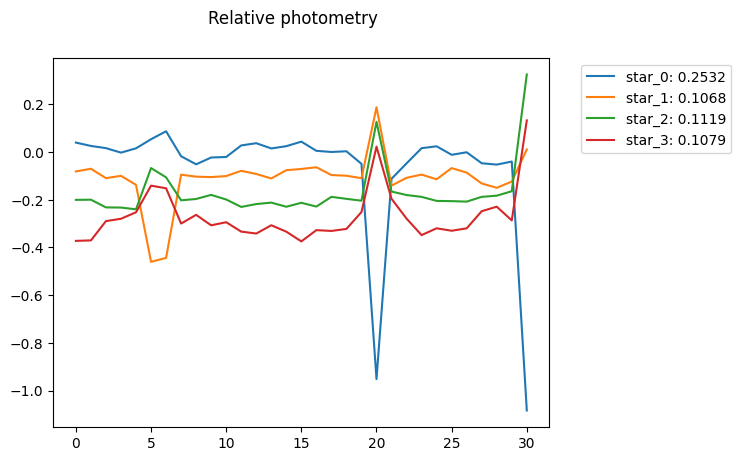

#################  Offset Plots  ####################


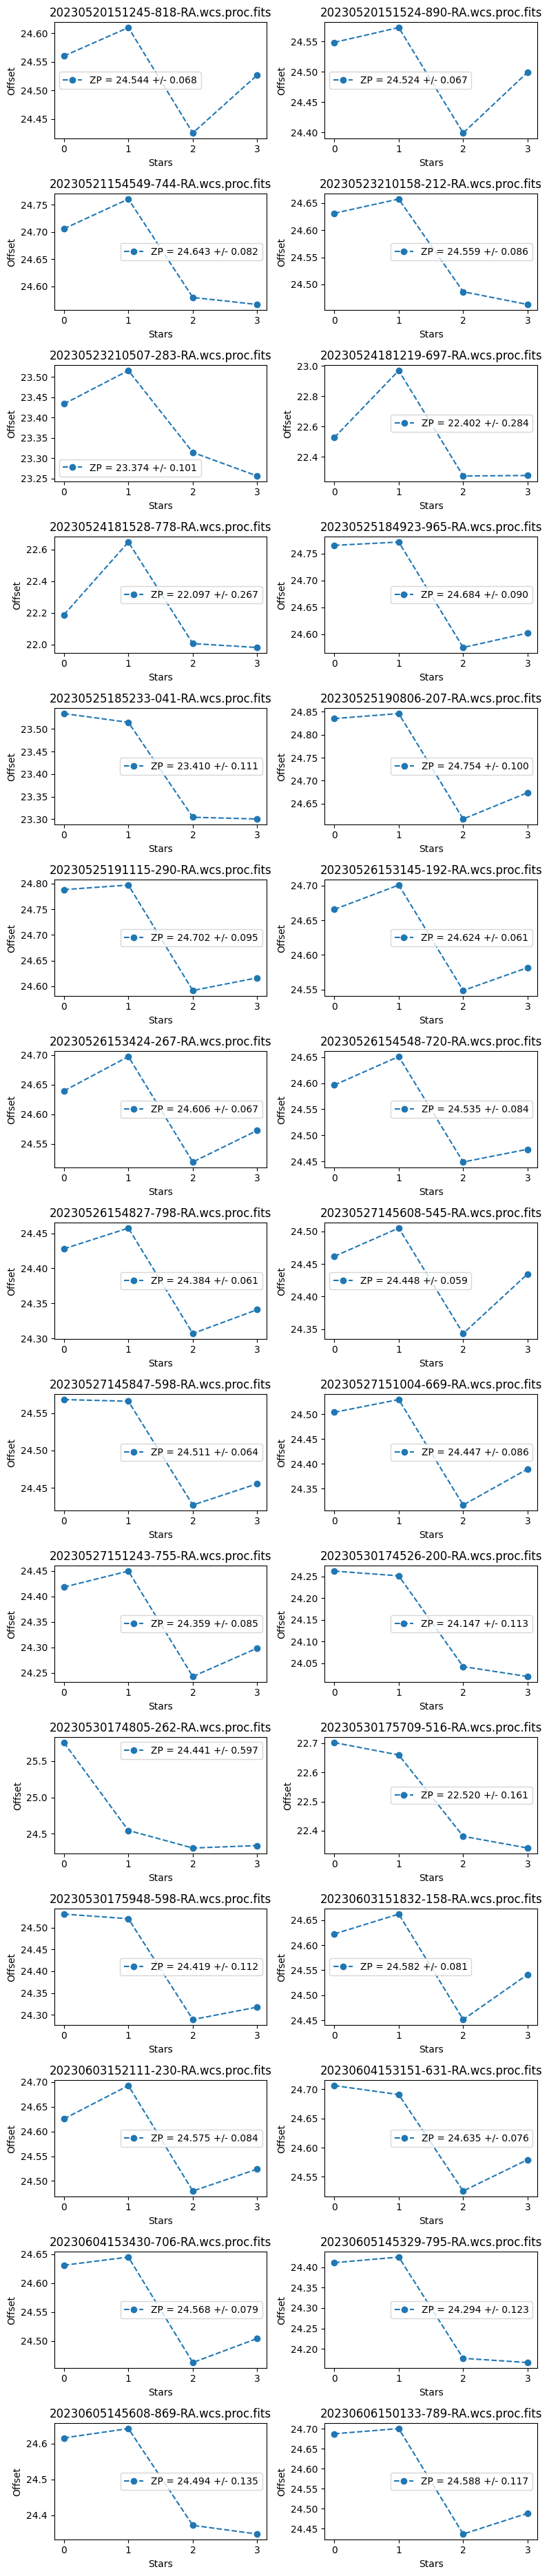

In [60]:
sel_stars = [0, 1, 2, 3, 4, 5]
rej_stars = [4,5]
print("#################  Relative Photometry  ####################")
get_rel_phot(data, sel_stars, rej_stars)
print("#################  Offset Plots  ####################")
ZP, ZP_err = get_ZP(data, sel_stars, rej_stars)

In [61]:
def plot_uband_mag(jd, target_mag, target_mag_err, ZP, ZP_err, title='u-band title'):
    cal_mag = target_mag + ZP
    cal_mag_err = (np.sqrt(target_mag_err**2 + ZP_err**2))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(jd, cal_mag, yerr=cal_mag_err,
                fmt='.', label='u-band', color='blue')
    ax.set_xlabel('JD')
    ax.set_ylabel('magnitude(AB)')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.gca().invert_yaxis()
    plt.show()
    return cal_mag, cal_mag_err

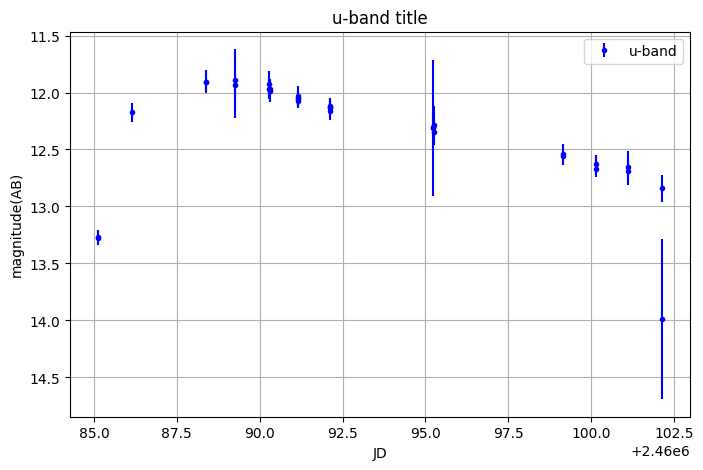

In [62]:
cal_mag, cal_mag_err = plot_uband_mag(jd, target_mag, target_mag_err, ZP, ZP_err, title='u-band title')

## Taking weighted mean of magnitudes of the same day

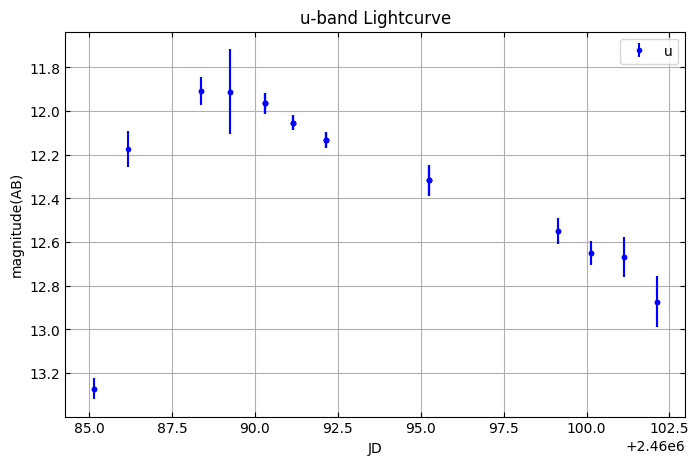

In [64]:
# To further reduce the error
tab = pd.DataFrame()
add_data = pd.DataFrame(columns=['Image', 'JD', 'mag', 'mag_err'])
tab['Image'] = image
tab['JD'] = jd
tab['Magnitude'] = cal_mag
tab['e_magnitude'] = cal_mag_err
tab['date'] = tab['Image'].str[:8]
# tab.to_csv('/mnt/disk1/vishwajeet/SN2023ixf/u_band/without_mean_u_band.csv', index=False)

jd_mean_ = []
mag_mean_ = []
e_mag_mean_ = []

for dat in tab['date']:
    condition = tab['date'] == dat
    jd_ = tab[condition]['JD']
    jd_mean = np.average(jd_)
    mag_ = tab[condition]['Magnitude']
    e_mag_ = tab[condition]['e_magnitude']
    pi = 1/e_mag_**2
    p = np.sum(pi)
    mag_mean = np.sum(mag_*pi)/p
    e_mag_mean = 1/np.sqrt(p)
    jd_mean_.append(jd_mean)
    mag_mean_.append(mag_mean)
    e_mag_mean_.append(e_mag_mean)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(jd_mean_, mag_mean_, yerr=e_mag_mean_,
            fmt='.', label='u', color='blue')
ax.set_xlabel('JD')
ax.set_ylabel('magnitude(AB)')
ax.set_title('u-band Lightcurve')
ax.grid(True)
plt.gca().invert_yaxis()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.legend()
plt.show()

## to save the weighted mean data
u_tab = pd.DataFrame()
add_data = pd.DataFrame(columns=['JD', 'mag', 'e_mag'])
u_tab['JD'] = jd_mean_
u_tab['Filter'] = ['u' for i in range(len(jd_mean_))]
u_tab['Magnitude'] = mag_mean_
u_tab['e_magnitude'] = e_mag_mean_
u_tab.to_csv('/home/aditi/ksp/u-band/data/weighted_u_band.csv', index=False)

# Combine all filters data

In [ ]:
file_u = '/home/aditi/ksp/u-band/data/weighted_u_band.csv'
file_g = '/home/aditi/ksp/g-band/data/g_SN2023ixf_Magnitude_table.csv'
file_r = '/home/aditi/ksp/r-band/data/r_SN2023ixf_Magnitude_table.csv'
file_i = '/home/aditi/ksp/i-band/data/i_SN2023ixf_Magnitude_table.csv'
file_z = '/home/aditi/ksp/u-band/data/z_SN2023ixf_Magnitude_table.csv'
filters = ['u', 'g', 'r', 'i', 'z']
file_paths = {
    'u': file_u,
    'g': file_g,
    'r': file_r,
    'i': file_i,
    'z': file_z
}

combined_table = pd.DataFrame()
for filt in filters:
    print("Filter", filt)
    file_data = pd.read_csv(file_paths[filt])
    file_data = file_data.sort_values(by='JD')
    temp_df = pd.DataFrame({
    'JD': file_data['JD'],
    'Filter': [filt for _ in range(len(file_data['JD']))],
    'Magnitude': file_data['Magnitude'],
    'e_magnitude': file_data['e_magnitude']
    })
    combined_table = pd.concat([combined_table, temp_df], ignore_index=True)
    
combined_table.to_csv('/mnt/disk1/vishwajeet/SN2023ixf/combined_table.csv', index=False)

Filter u
Filter g
Filter r
Filter i
Filter z


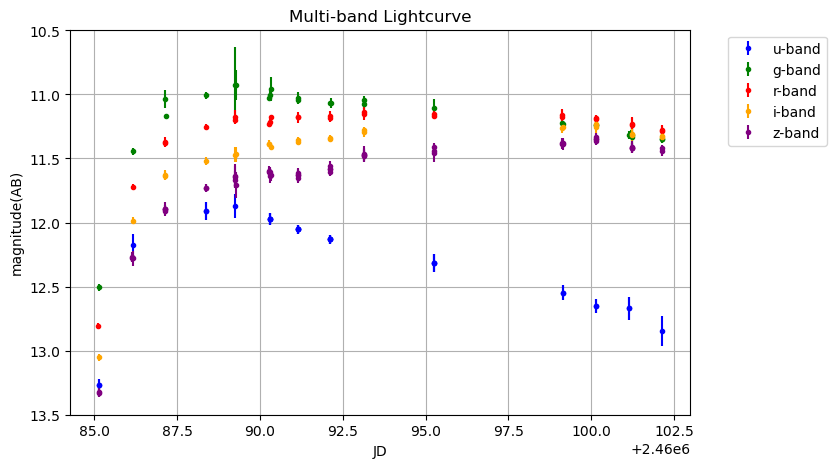

In [ ]:
file = '/mnt/disk1/vishwajeet/SN2023ixf/combined_table.csv'
frame = pd.read_csv(file)
frame_u = frame[frame['Filter']=='u']
frame_g = frame[frame['Filter']=='g']
frame_r = frame[frame['Filter']=='r']
frame_i = frame[frame['Filter']=='i']
frame_z = frame[frame['Filter'] == 'z']

bands = ['u', 'g', 'r', 'i', 'z']

jd = {
    'u': frame_u['JD'],
    'g': frame_g['JD'],
    'r': frame_r['JD'],
    'i': frame_i['JD'],
    'z': frame_z['JD']
}


mag = {
    'u': frame_u['mag'],
    'g': frame_g['mag'],
    'r': frame_r['mag'],
    'i': frame_i['mag'],
    'z': frame_z['mag']
}

mag_err = {
    'u': frame_u['e_mag'],
    'g': frame_g['e_mag'],
    'r': frame_r['e_mag'],
    'i': frame_i['e_mag'],
    'z': frame_z['e_mag']
}

color_map = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'orange',
    'z': 'purple'
}

# Plot the lightcurve for each band
fig, ax = plt.subplots(figsize=(8, 5))
for band in bands:
    ax.errorbar(jd[band], mag[band], yerr=mag_err[band],
                fmt='.', label=f'{band}-band', color=color_map[band])
ax.set_xlabel('JD')
ax.set_ylabel('magnitude(AB)')
ax.set_title('Multi-band Lightcurve')
ax.grid(True)
plt.gca().invert_yaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
